In [24]:
import pandas as pd
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import torch
#import umap

import sys
sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training

# --- Initialize parameters ---
pdir = "/home/kkumbier/als/scripts/maps/template_analyses/params/"
with open(pdir + "multiclass-3-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir + "multiclass-3-test.json", "r") as f:
    test_params = json.load(f)

with open(pdir + "multiclass-sporadic.json", "r") as f:
    sporadic_params = json.load(f)

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 4

antibodies = ["HSP70/SOD1", "FUS/EEA1", "COX IV/Galectin3/atubulin"]
print(json.dumps(train_params, indent=4))


{
    "name": "maps_dmso",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "drop_sample_by_feature": {
            "drop_key": [
                {
                    "CellLines": [
                        "C9014",
                        "NS048"
                    ]
                }
            ]
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ],
                    "Mutations": [
                        "FUS",
                        "WT",
                        "SOD1",
                        "C9orf72"
                    ],
                    "CellLines": [
                        "NS007",
                        

In [3]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

sporadic_screen = ImageScreenMultiAntibody(sporadic_params)
sporadic_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

print("Processing sporadic set...")
sporadic_screen.preprocess()

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")
    print(f"Sporadic data: {sporadic_screen.data[ab].shape}")

Processing training set...
Processing test set...
Processing test set...
Processing sporadic set...
Processing sporadic set...
Marker set: HSP70/SOD1
Train data: (17685, 311)
Test data: (81834, 311)
Sporadic data: (13782, 311)
Marker set: FUS/EEA1
Train data: (18154, 315)
Test data: (84098, 315)
Sporadic data: (14465, 315)
Marker set: COX IV/Galectin3/atubulin
Train data: (17074, 312)
Test data: (78320, 312)
Sporadic data: (14337, 312)
Marker set: HSP70/SOD1
Train data: (17685, 311)
Test data: (81834, 311)
Sporadic data: (13782, 311)
Marker set: FUS/EEA1
Train data: (18154, 315)
Test data: (84098, 315)
Sporadic data: (14465, 315)
Marker set: COX IV/Galectin3/atubulin
Train data: (17074, 312)
Test data: (78320, 312)
Sporadic data: (14337, 312)


In [8]:
import importlib
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader


dataloader_config.batch_size = 6
response_map = {"WT": 0, "FUS": 1, "SOD1": 2, "C9orf72": 3, "sporadic": 4}
dataloader_config.response_map["Mutations"] = response_map

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

scalers = train_dataloader._get_scalers()
dataloader_config.mode = "eval"
test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=scalers,
    **vars(dataloader_config)
)

dataloader_config.mode = "eval"
sporadic_dataloader = create_multiantibody_dataloader(
    sporadic_screen,
    scalers=scalers,
    **vars(dataloader_config)
)

In [28]:
batch = next(iter(train_dataloader))
batch["FUS/EEA1"][0].shape

{'HSP70/SOD1': 310, 'FUS/EEA1': 314, 'COX IV/Galectin3/atubulin': 311}

In [29]:
dataloader = train_dataloader
config = train_config

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from maps.multiantibody.config import TrainConfig
from maps.multiantibody.models import MultiAntibodyClassifier
import wandb


# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Split model parameters by hierarchy level - cell vs patient
line_param_ids = set()
for module in [model.pooling, model.aggregation, model.line_head]:
    for param in module.parameters():
        line_param_ids.add(id(param))

cell_params, line_params = [], []
for _, param in model.named_parameters(): 
    if param.requires_grad and id(param) not in line_param_ids:
        cell_params.append(param)
    elif param.requires_grad and id(param) in line_param_ids:
        line_params.append(param)

# Scheduler step interval (default 10)
scheduler_step = getattr(config, 'scheduler_step', 10)

# Create optimizers - will be updated as parameters are frozen
def create_cell_optimizer():
    """Create optimizer for currently trainable cell parameters"""
    trainable_cell_params = []
    for _, param in model.named_parameters():
        if (param.requires_grad and 
            id(param) not in line_param_ids):
            trainable_cell_params.append(param)
    
    if trainable_cell_params:
        return optim.Adam(
            trainable_cell_params,
            lr=config.lr,
            betas=config.betas,
            weight_decay=config.weight_decay
        )
    return None

optimizer_cell = create_cell_optimizer()
optimizer_line = optim.Adam(
    line_params,
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay
)

# Learning rate schedulers
scheduler_cell = None
if optimizer_cell is not None:
    scheduler_cell = optim.lr_scheduler.StepLR(optimizer_cell, step_size=scheduler_step, gamma=0.5)

scheduler_line = optim.lr_scheduler.StepLR(optimizer_line, step_size=scheduler_step, gamma=0.5)

criterion_cell = nn.CrossEntropyLoss()
criterion_line = nn.CrossEntropyLoss()

# Early stopping parameters
patience = getattr(config, 'patience', 5)
min_delta = 1e-6

if config.verbose:
    print("Starting cell-level training...")

# --- Phase 1: Cell-level training ---
# Per-antibody early stopping tracking
best_loss_per_ab = {ab: float('inf') for ab in model.antibodies}
epochs_no_improve_per_ab = {ab: 0 for ab in model.antibodies}
frozen_antibodies = set()
active_antibodies = set(model.antibodies) 

model.train()

Starting cell-level training...


Starting cell-level training...


MultiAntibodyClassifier(
  (encoders): ModuleDict(
    (COX IV/Galectin3/atubulin): AntibodyEncoder(
      (batch_norm): BatchNorm1d(311, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (encoder): Sequential(
        (0): Linear(in_features=311, out_features=16, bias=True)
        (1): ReLU()
        (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (FUS/EEA1): AntibodyEncoder(
      (batch_norm): BatchNorm1d(314, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (encoder): Sequential(
        (0): Linear(in_features=314, out_features=16, bias=True)
        (1): ReLU()
        (2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (HSP70/SOD1): AntibodyEncoder(
      (batch_norm): BatchNorm1d(310, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (encoder): Sequential(
        (0): Linear(in_fe

In [49]:
batch = next(iter(dataloader))

# Prepare batch data
x_dict = {ab: batch[ab][0].to(device) for ab in batch}
y_dict = {ab: batch[ab][1].to(device) for ab in batch}
            

In [42]:
importlib.reload(training)
importlib.reload(models)
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 5e-3

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model = MultiAntibodyClassifier(**vars(model_config))
train(model, train_dataloader, train_config)

Starting cell-level training...


Starting cell-level training...


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 48])

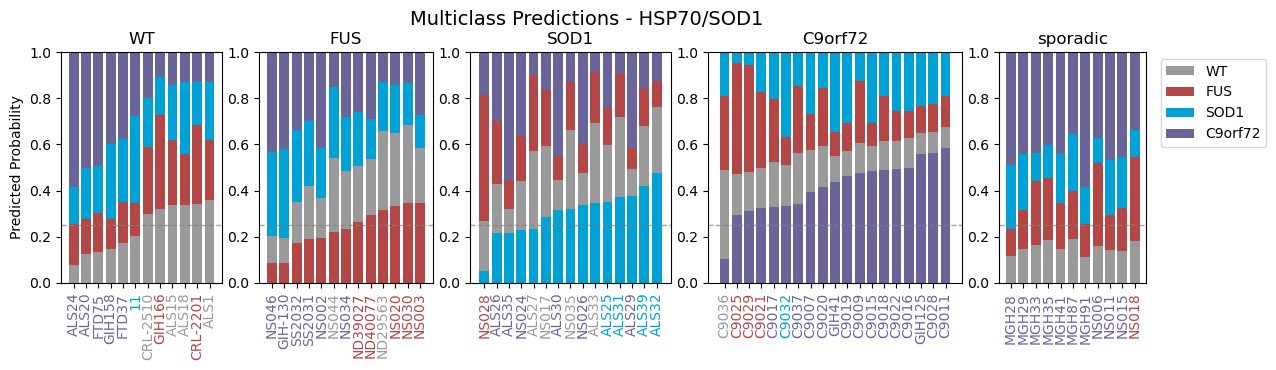

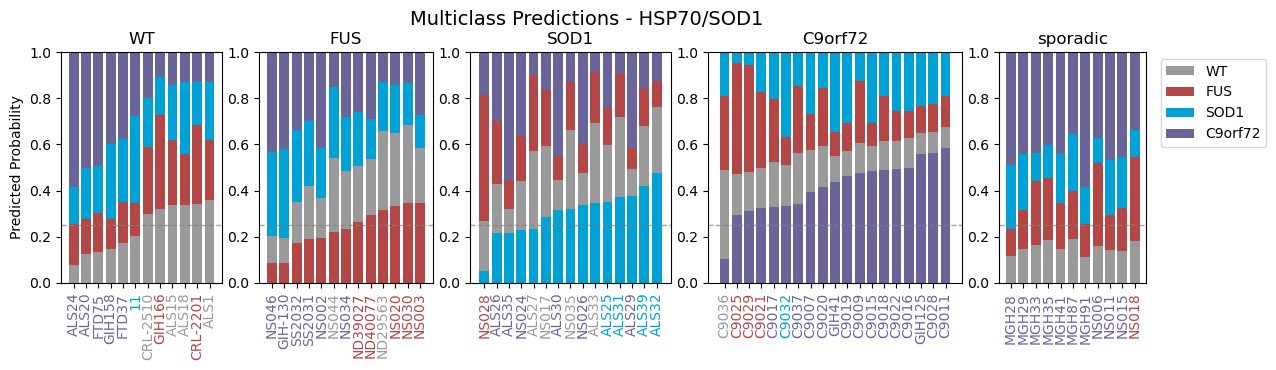

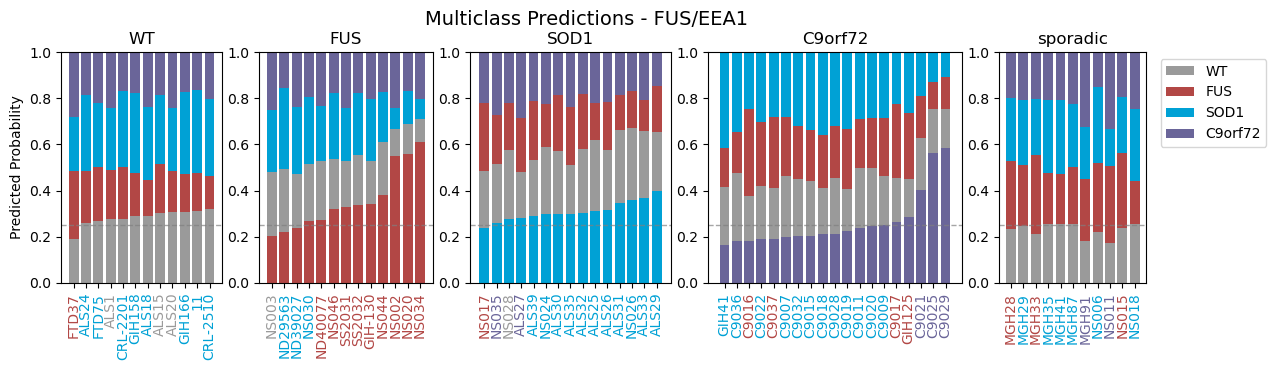

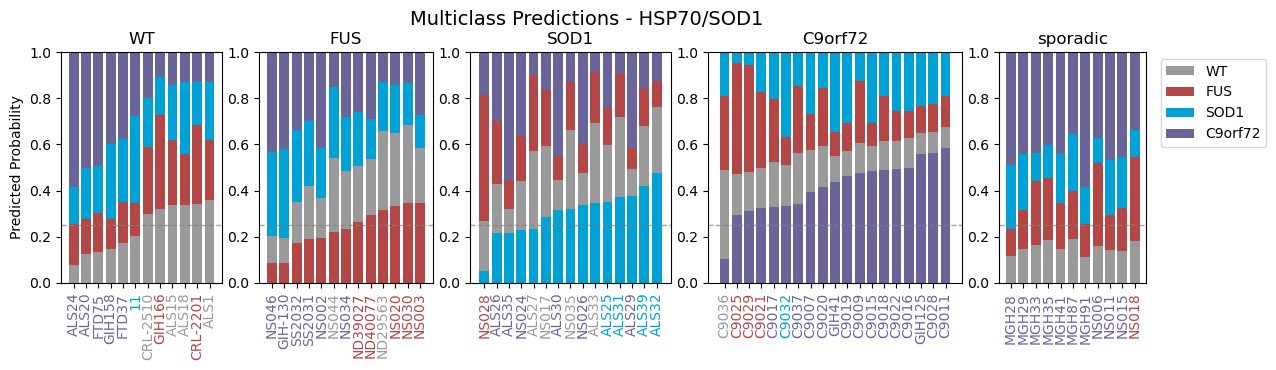

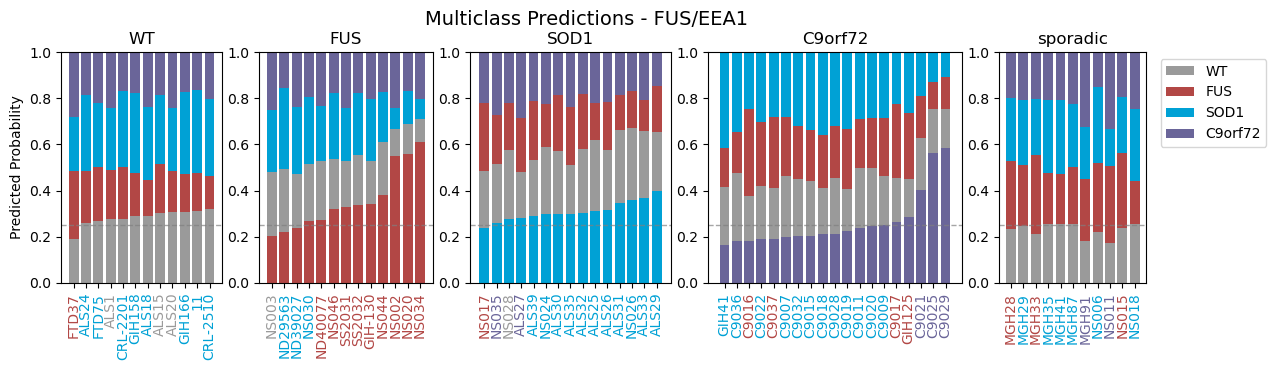

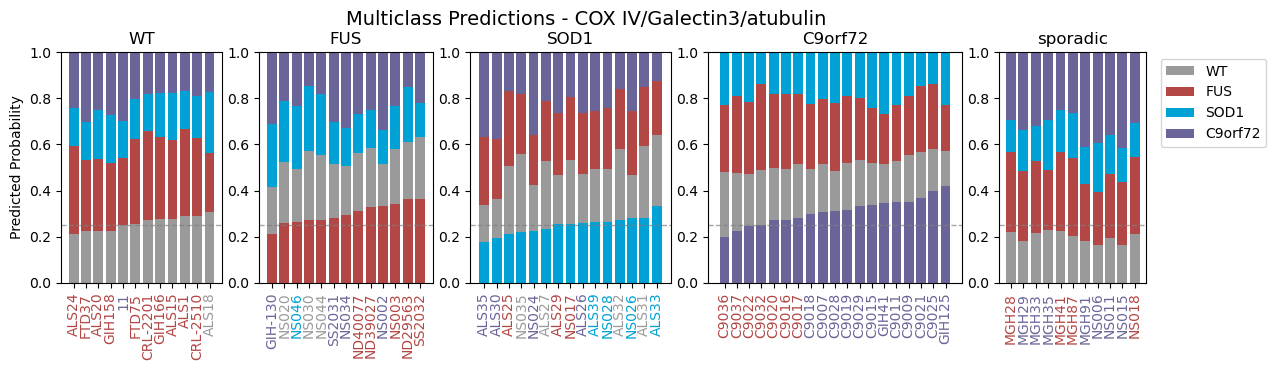

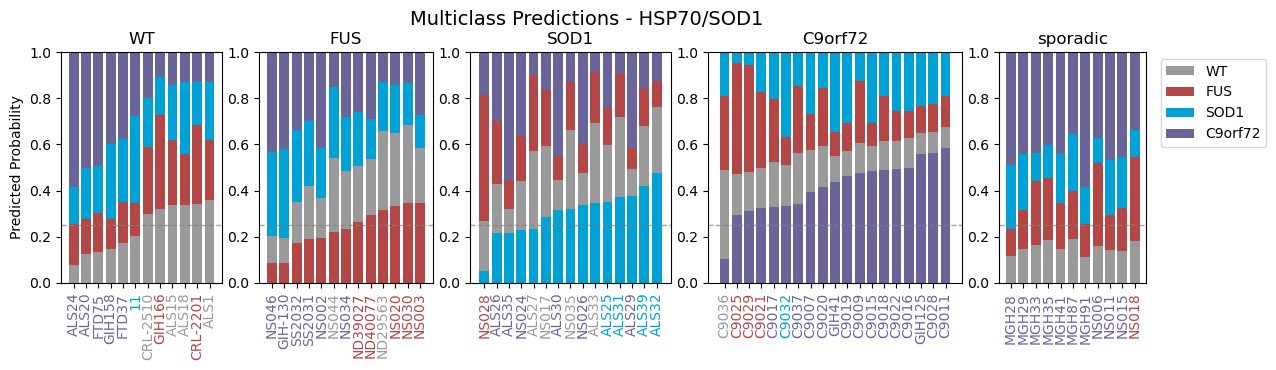

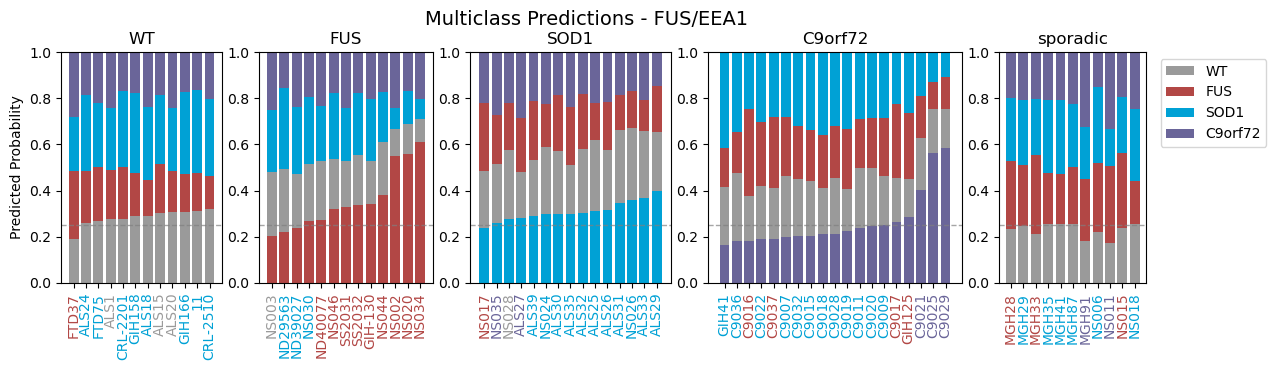

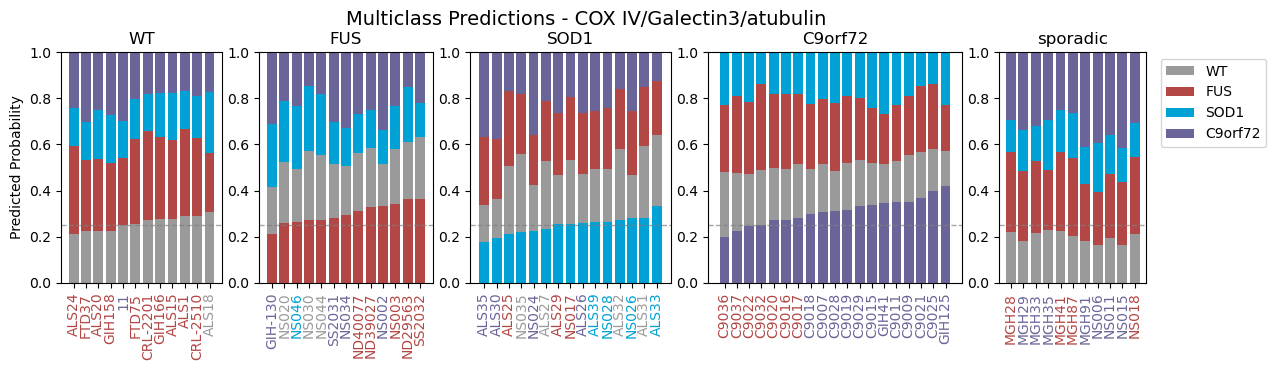

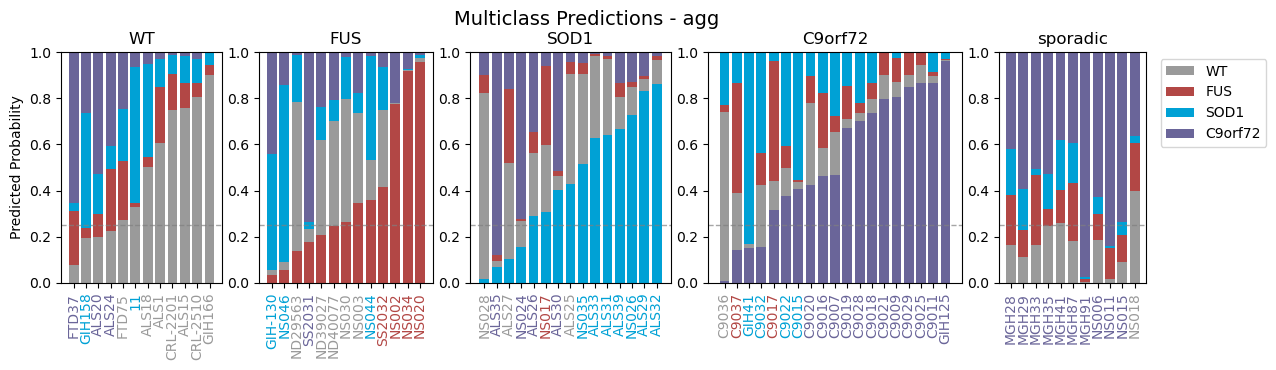

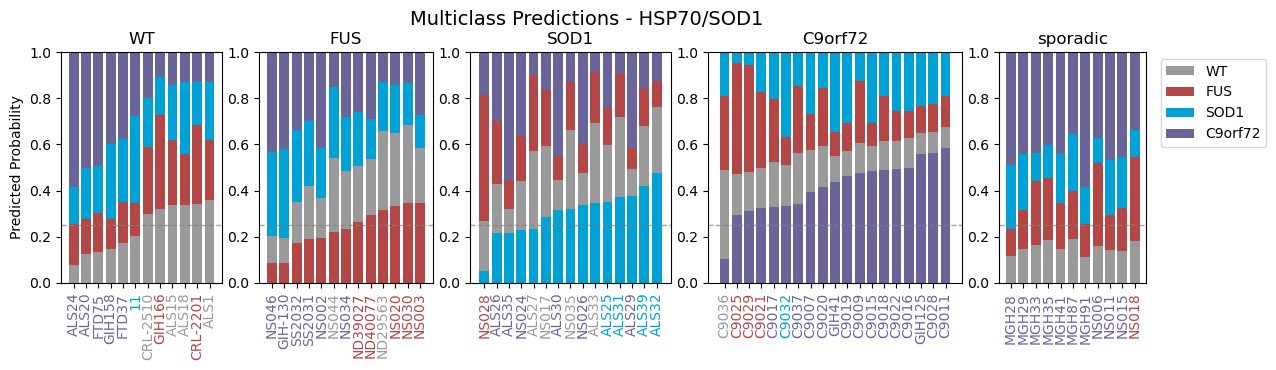

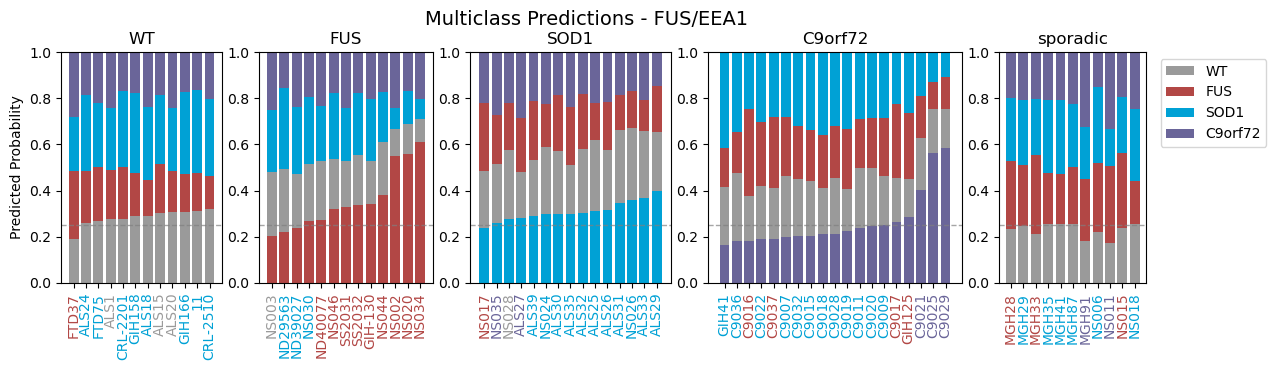

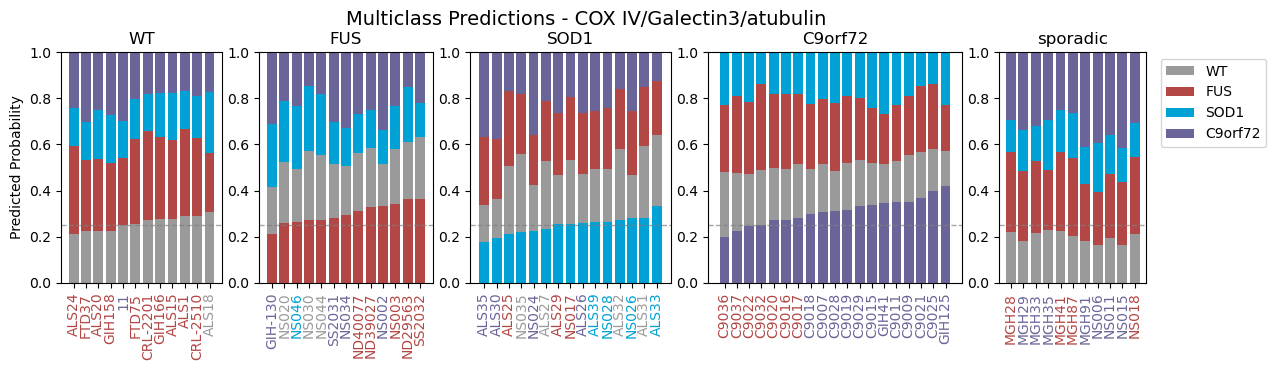

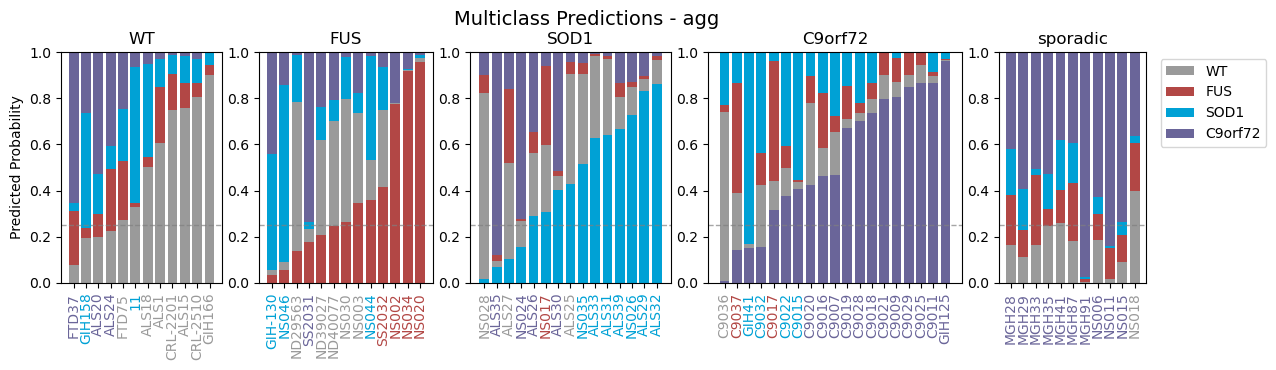

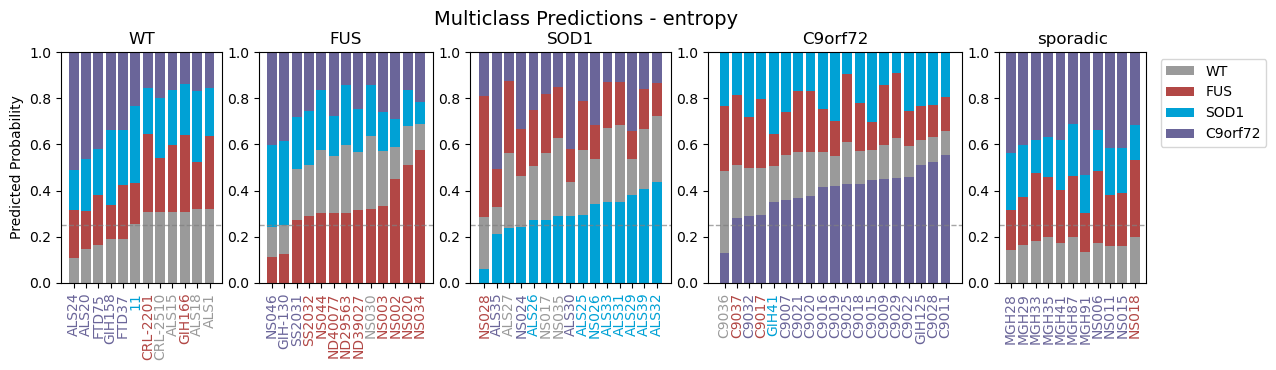

In [43]:
from plotnine import geom_point, scale_color_manual

int_to_mut = {v: k for k, v in response_map.items()}
labels = df['True'].map(int_to_mut)

# Prepare DataFrame for individual antibody UMAPs
for ab, emb in embeddings.items():
    reducer = umap.UMAP(random_state=42)
    emb_2d = reducer.fit_transform(emb.cpu().numpy())
    df_umap = pd.DataFrame({
        "UMAP1": emb_2d[:, 0],
        "UMAP2": emb_2d[:, 1],
        "Label": labels
    })
    p = (
        ggplot(df_umap, aes(x="UMAP1", y="UMAP2", color="Label")) +
        geom_point(size=3) +
        scale_color_manual(values=PALETTE) +
        labs(color="") +
        ggtitle(f"UMAP of {ab} embeddings") +
        theme_bw()
    )
    
    display(p)

In [44]:
# Compute performance metrics for each class and marker combination
from sklearn.metrics import roc_auc_score, log_loss
import numpy as np

# Create results list to store metrics
results = []

# Get true labels
true_labels = df['True'].values

# Iterate over each antibody marker
for marker in probs_cell:
    marker_probs = probs_cell[marker].numpy()
    
    # Iterate over each class
    for class_idx in range(4):
        class_name = int_to_mut[class_idx]
        
        # Binary labels for this class (1 if true class, 0 otherwise)
        binary_labels = (true_labels == class_idx).astype(int)
        
        # Predicted probabilities for this class
        class_probs = marker_probs[:, class_idx]
        
        # Compute accuracy in one-vs-all setting using argmax prediction
        predicted_class = np.argmax(marker_probs, axis=1)
        predicted_labels = (predicted_class == class_idx).astype(int)
        accuracy = (predicted_labels == binary_labels).mean()
        
        # Compute AUROC (class vs all others)
        if len(np.unique(binary_labels)) > 1:  # 
            auroc = roc_auc_score(binary_labels, class_probs)
        else:
            auroc = np.nan  # Cannot compute AUROC with only one class
        
        # Compute cross entropy in one-vs-all setting (current class as 1, all others as 0)
        eps = 1e-15
        clipped_probs = np.clip(class_probs, eps, 1-eps)
        cross_entropy = -np.mean(binary_labels * np.log(clipped_probs) + 
                               (1 - binary_labels) * np.log(1 - clipped_probs))
        
        # Store results
        results.append({
            'marker': marker,
            'class': class_name,
            'accuracy': accuracy,
            'auroc': auroc,
            'cross_entropy': cross_entropy
        })

# Create DataFrame with results
metrics_df = pd.DataFrame(results)
print("Performance metrics by marker and class:")
print(metrics_df.round(4))

NameError: name 'embeddings' is not defined

In [50]:
# Create barplots showing accuracy, AUROC, and cross entropy by marker for each class (merged over classes, including aggregate predictions)
from plotnine import ggplot, aes, geom_bar, theme_bw, theme, element_text, labs, ggtitle, scale_fill_manual, coord_cartesian, geom_text, position_dodge

# --- Compute aggregate metrics using probs_line ---
from sklearn.metrics import roc_auc_score, log_loss
import numpy as np

agg_results = []
true_labels = df['True'].values
agg_probs = probs_line.numpy()

for class_idx in range(4):
    class_name = int_to_mut[class_idx]
    binary_labels = (true_labels == class_idx).astype(int)
    class_probs = agg_probs[:, class_idx]
    predicted_class = np.argmax(agg_probs, axis=1)
    predicted_labels = (predicted_class == class_idx).astype(int)
    accuracy = (predicted_labels == binary_labels).mean()
    if len(np.unique(binary_labels)) > 1:
        auroc = roc_auc_score(binary_labels, class_probs)
    else:
        auroc = np.nan
    eps = 1e-15
    clipped_probs = np.clip(class_probs, eps, 1-eps)
    cross_entropy = -np.mean(binary_labels * np.log(clipped_probs) + (1 - binary_labels) * np.log(1 - clipped_probs))
    agg_results.append({
        'marker': 'Aggregate',
        'class': class_name,
        'accuracy': accuracy,
        'auroc': auroc,
        'cross_entropy': cross_entropy
    })

agg_metrics_df = pd.DataFrame(agg_results)

# --- Merge with per-marker metrics ---
metrics_merged = pd.concat([metrics_df, agg_metrics_df], ignore_index=True)

# Reshape data for faceting (melt to long format)
plot_data = metrics_merged.melt(
    id_vars=['marker', 'class'], 
    value_vars=['accuracy', 'auroc', 'cross_entropy'],
    var_name='metric', 
    value_name='value'
 )

# Create categorical ordering for markers and classes
plot_data['marker'] = pd.Categorical(
    plot_data['marker'], 
    categories=antibodies + ['Aggregate'], 
    ordered=True
)
plot_data['class'] = pd.Categorical(
    plot_data['class'], 
    categories=['WT', 'FUS', 'SOD1', 'C9orf72'], 
    ordered=True
)

# Plot for each metric, with class as x-axis and marker as fill/color
for metric in ['accuracy', 'auroc', 'cross_entropy']:
    metric_data = plot_data[plot_data['metric'] == metric].copy()
    
    # Set appropriate y-limits and label offset
    if metric in ['accuracy', 'auroc']:
        y_limits = (0.5, 1.0)
        y_offset = 0.02
    else:  # cross_entropy
        y_limits = (0.4, 0.6)
        y_offset = 0.07
    
    # Add a column for value labels as float (not string)
    metric_data['label'] = metric_data['value'].round(2)
    metric_data['y_label'] = metric_data['value'] + y_offset
    
    dodge = position_dodge(width=0.7)
    
    p = (
        ggplot(metric_data, aes(x='class', y='value', fill='marker')) +
        geom_bar(stat='identity', position=dodge, width=0.7) +
        #geom_text(aes(label='label', y='y_label', group='marker'), format_string='{:.2f}', size=10, position=dodge, angle=90) +
        coord_cartesian(ylim=y_limits) +
        theme_bw() +
        theme(
            text=element_text(size=12),
            figure_size=(8, 4),
            legend_position='right'
        ) +
        labs(
            x='Class',
            y=metric.replace('_', ' ').title(),
            fill='Marker'
        ) +
        scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c', '#8c564b'])
    )
    
    display(p)

Performance metrics by marker and class:
                       marker    class  accuracy   auroc  cross_entropy
0   COX IV/Galectin3/atubulin       WT    0.7288  0.7642         0.4783
1   COX IV/Galectin3/atubulin      FUS    0.4915  0.5134         0.5419
2   COX IV/Galectin3/atubulin     SOD1    0.7966  0.7833         0.5254
3   COX IV/Galectin3/atubulin  C9orf72    0.6610  0.7842         0.5702
4                    FUS/EEA1       WT    0.7966  0.7801         0.4769
5                    FUS/EEA1      FUS    0.8305  0.8679         0.4384
6                    FUS/EEA1     SOD1    0.5932  0.6909         0.5350
7                    FUS/EEA1  C9orf72    0.6949  0.6079         0.6154
8                  HSP70/SOD1       WT    0.7458  0.6117         0.4955
9                  HSP70/SOD1      FUS    0.7627  0.6120         0.5323
10                 HSP70/SOD1     SOD1    0.7966  0.7561         0.5149
11                 HSP70/SOD1  C9orf72    0.6441  0.7579         0.5376


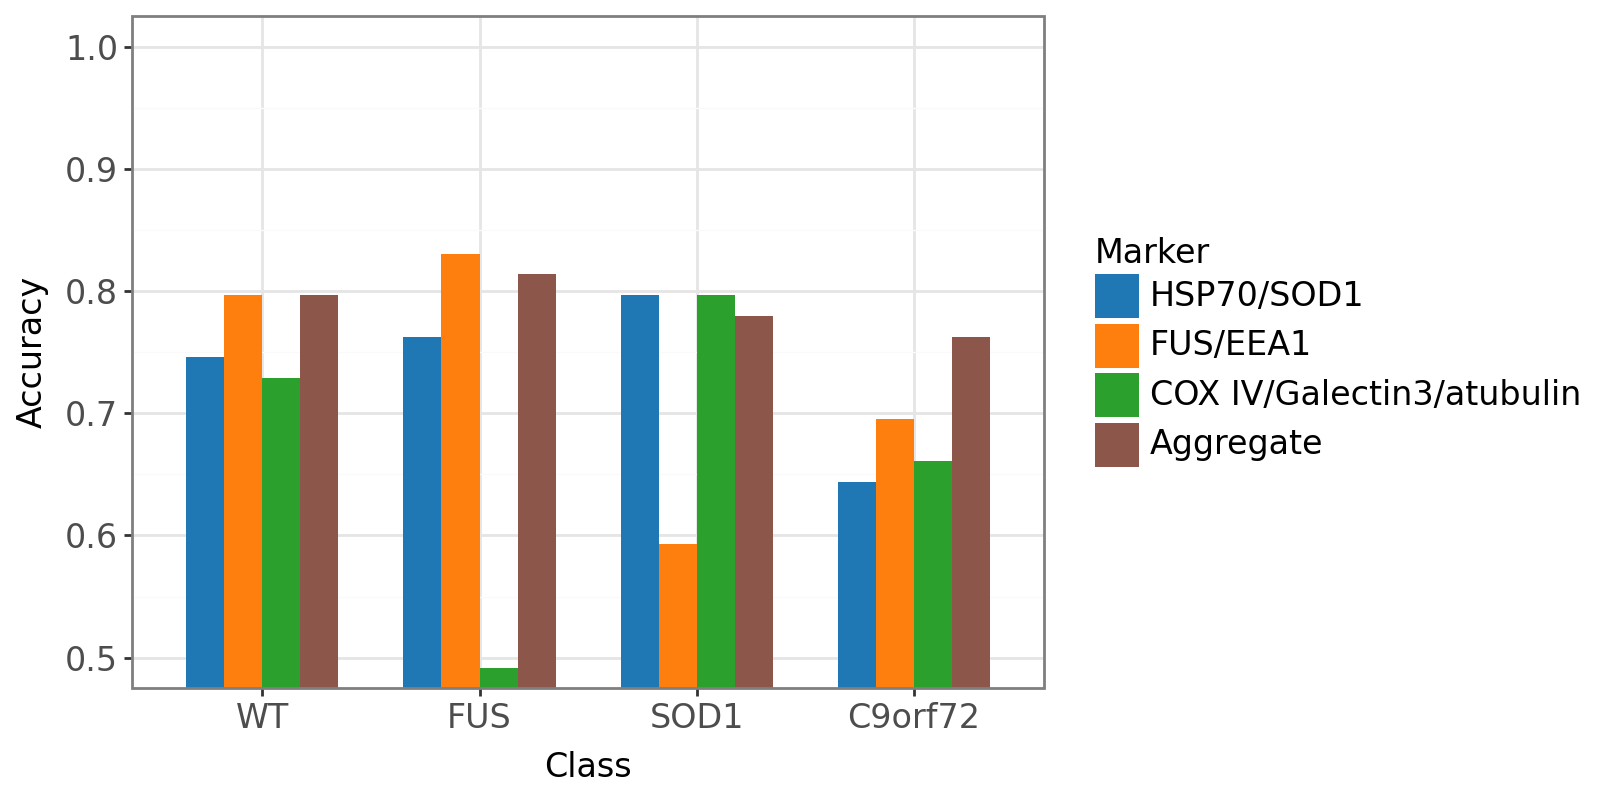

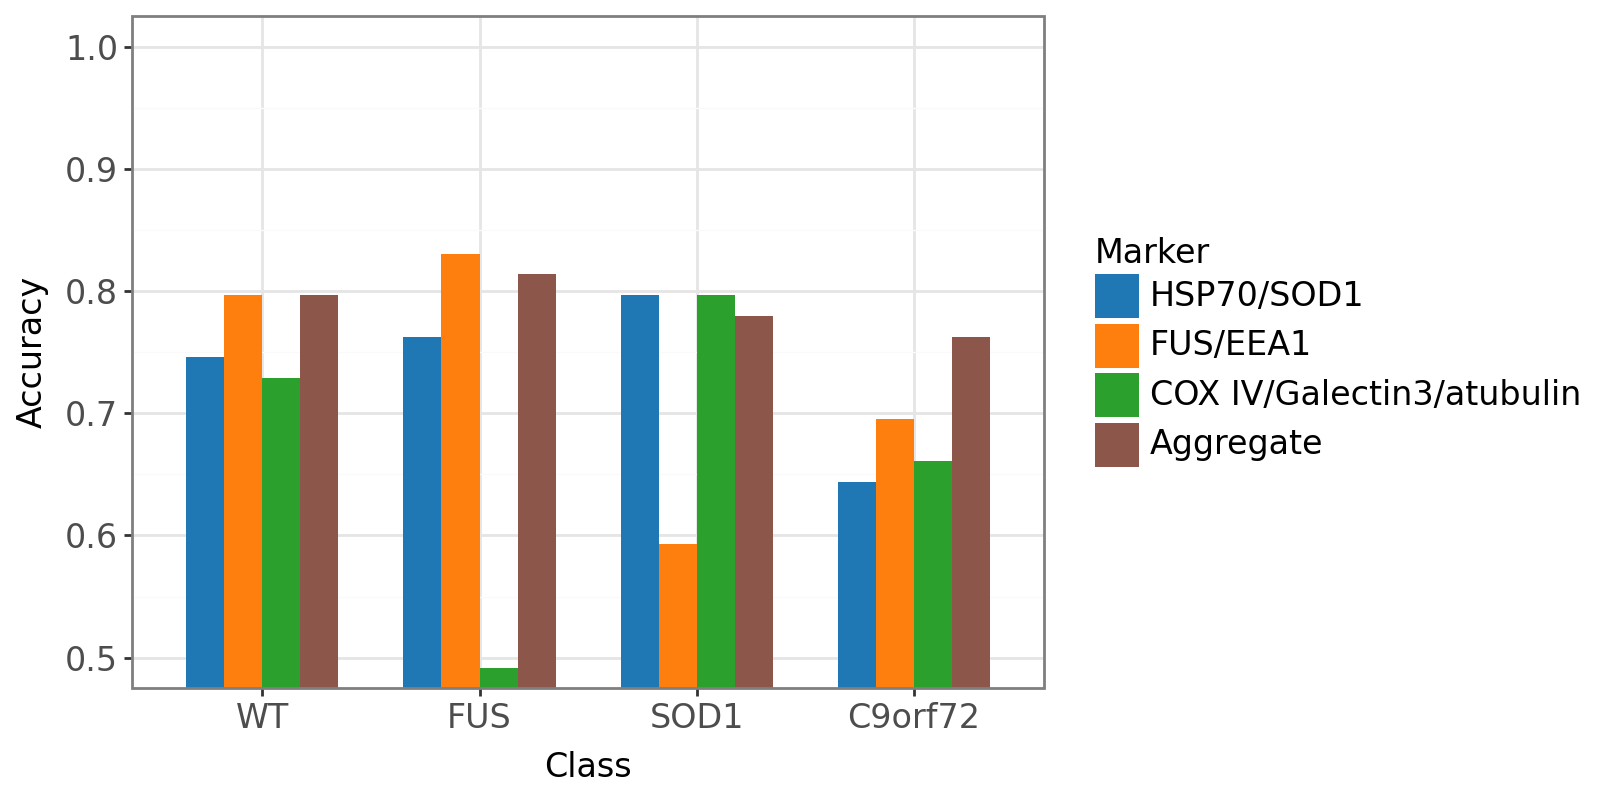

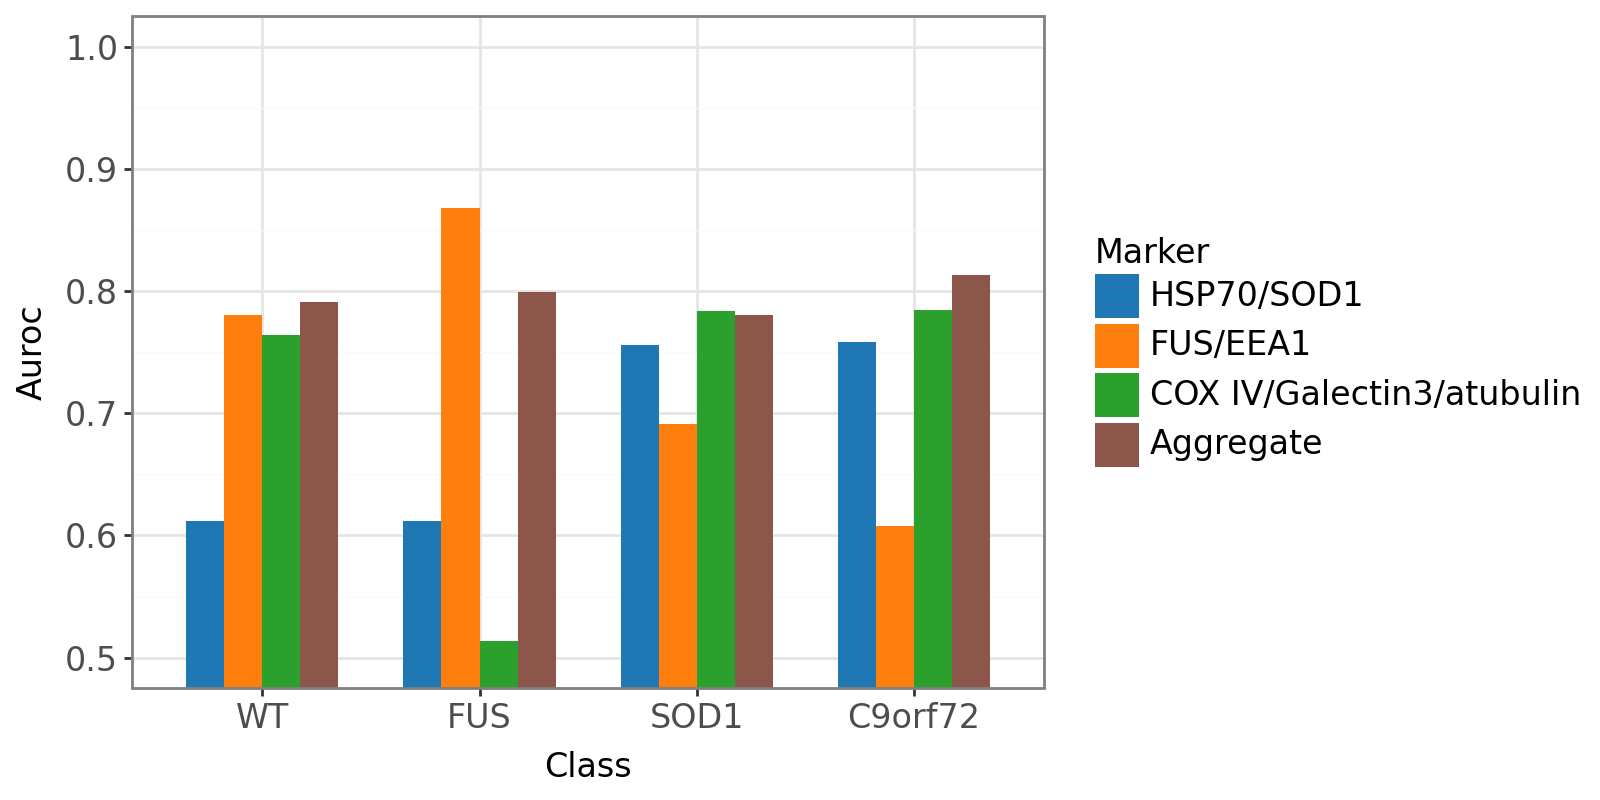

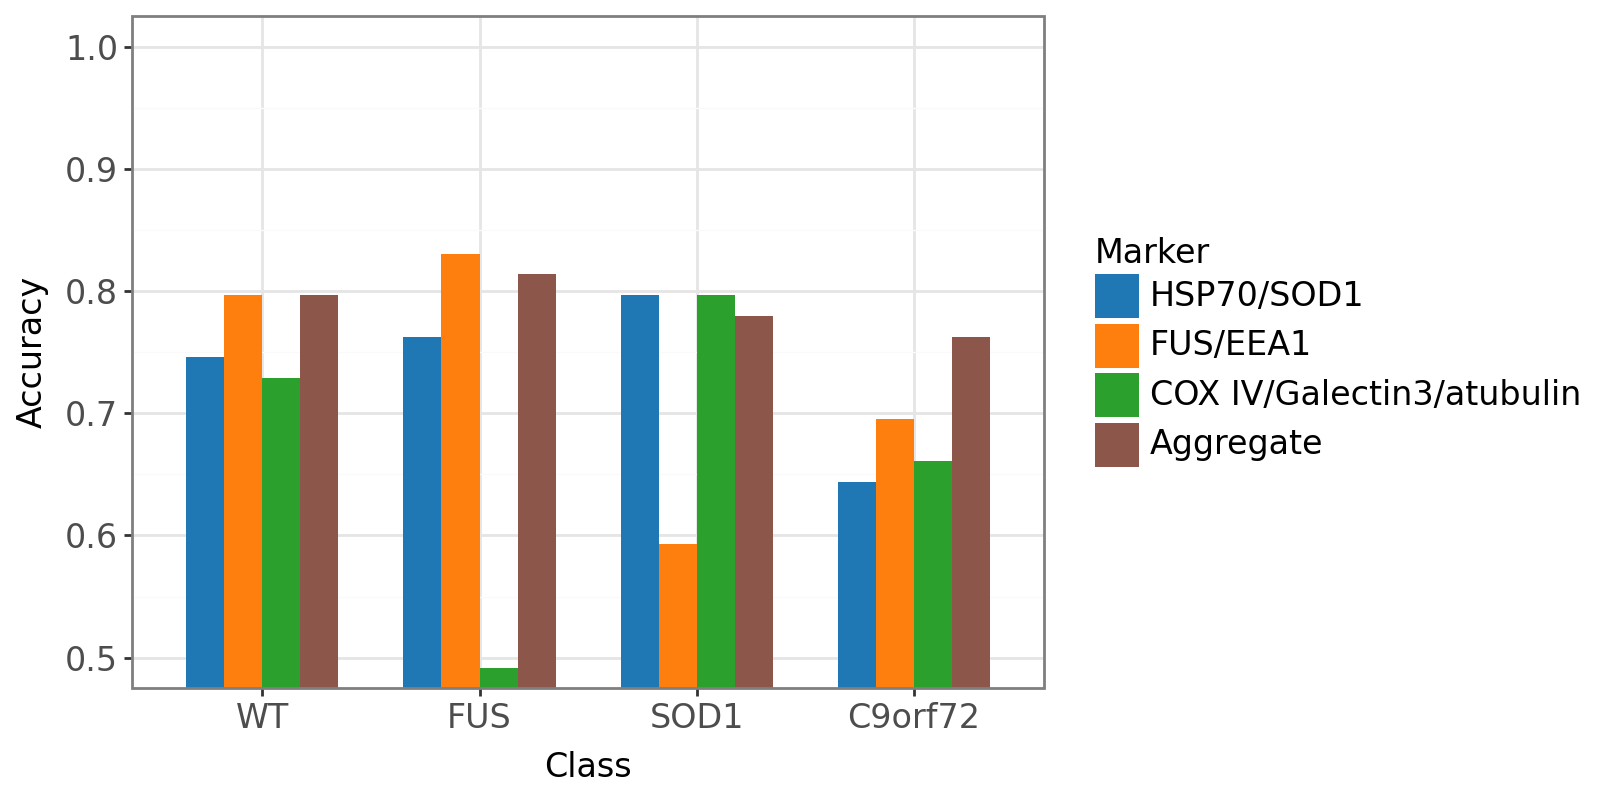

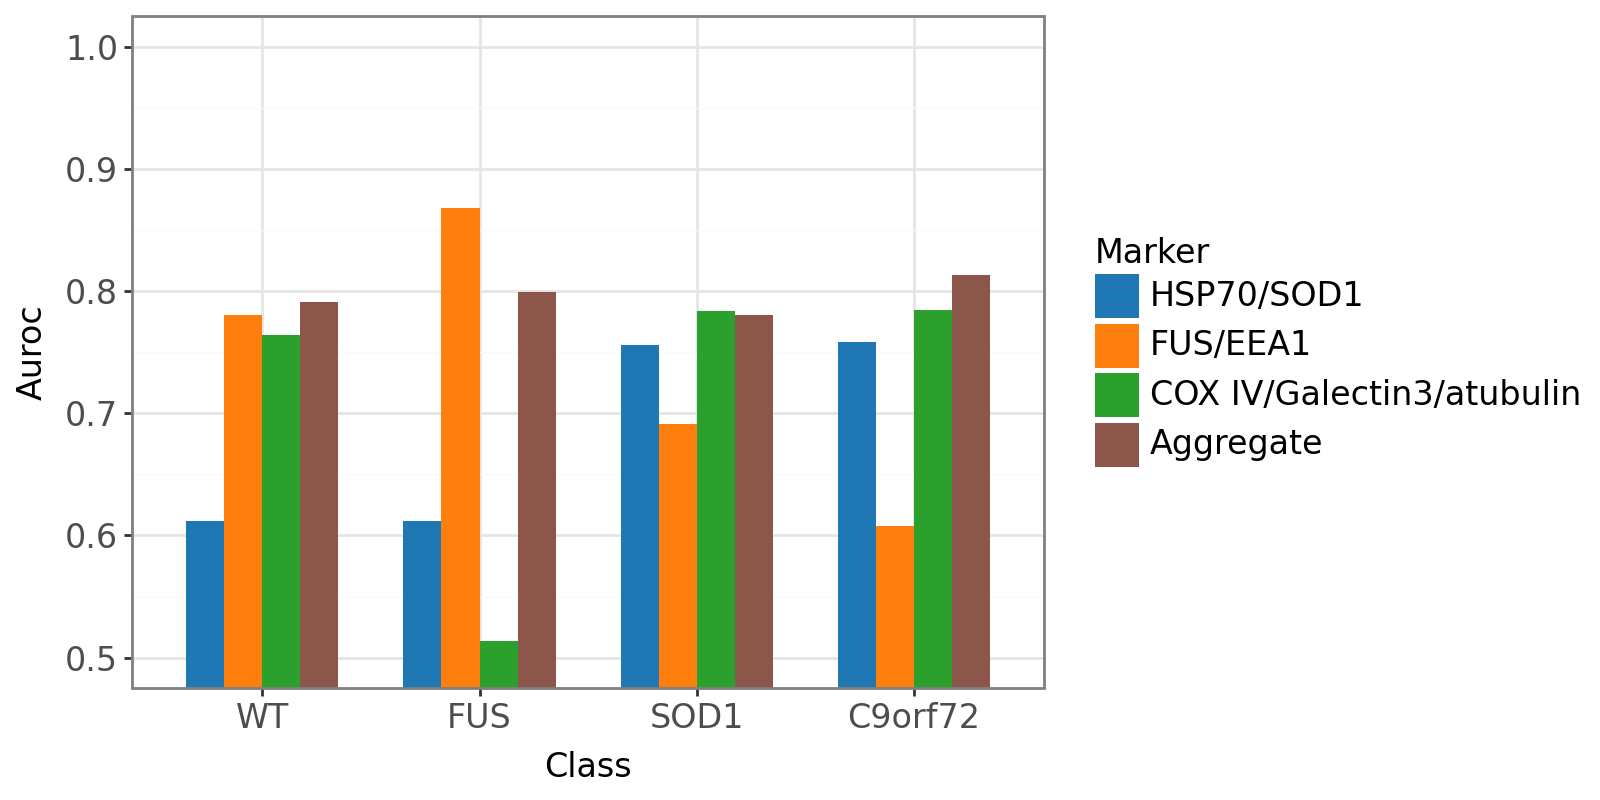

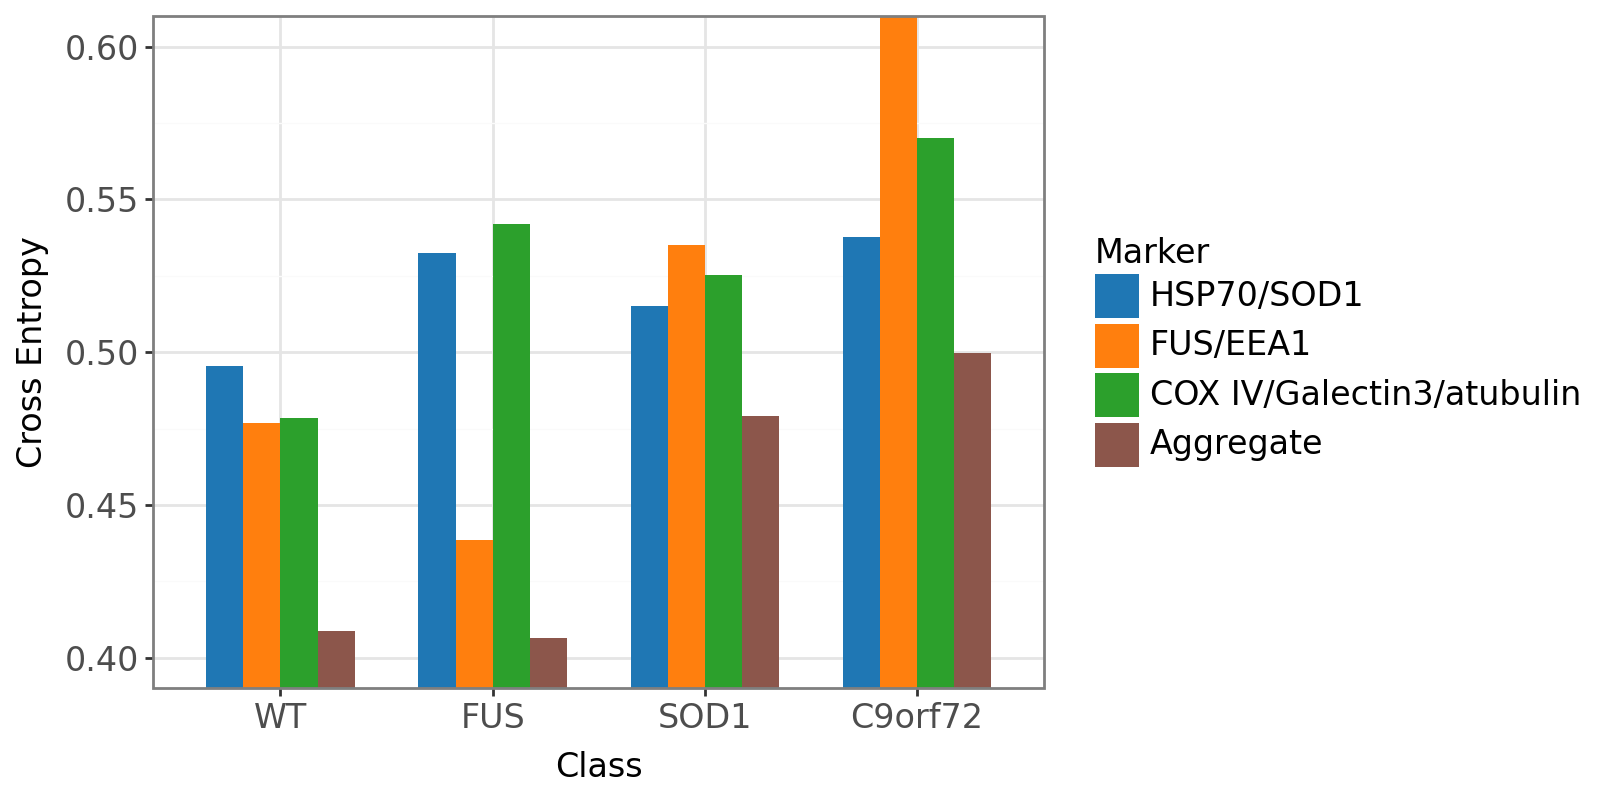

In [51]:
# Create UMAP from concatenated embeddings across all antibody markers
from plotnine import geom_point, scale_color_manual

# Concatenate embeddings from all antibodies
all_embeddings = []
for ab in antibodies:
    if ab in embeddings:
        all_embeddings.append(embeddings[ab])

# Concatenate along feature dimension (axis=1)
if all_embeddings:
    concat_embeddings = torch.cat(all_embeddings, dim=1)
    
    # Create UMAP from concatenated embeddings
    reducer = umap.UMAP(random_state=42)
    emb_2d = reducer.fit_transform(concat_embeddings.cpu().numpy())
    
    labels = df['True'].map(int_to_mut)
    
    df_umap_concat = pd.DataFrame({
        "UMAP1": emb_2d[:, 0],
        "UMAP2": emb_2d[:, 1],
        "Label": labels
    })
    
    p = (
        ggplot(df_umap_concat, aes(x="UMAP1", y="UMAP2", color="Label")) +
        geom_point(size=3) +
        scale_color_manual(values=PALETTE) +
        labs(color="") +
        ggtitle("UMAP of Concatenated Multi-Antibody Embeddings") +
        theme_bw()
    )
    
    display(p)
else:
    print("No embeddings found to concatenate")